## Sagnac Frequency - Backscatter Correction - RV Tilt

Explore the longterm behaviour of the RU sagnac beat

## Imports

In [5]:
import os
import gc
import matplotlib.pyplot as plt
import numpy as np

from datetime import datetime, date
from pandas import DataFrame, read_pickle, date_range, concat, read_csv
from obspy import UTCDateTime, read, Trace, Stream, read_inventory
from scipy.signal import hilbert

from functions.get_fft import __get_fft
from functions.multitaper_psd import __multitaper_psd
from functions.welch_psd import __welch_psd
from functions.compute_cwt import __compute_cwt
from functions.sagnac_to_tilt import __sagnac_to_tilt

from andbro__read_sds import __read_sds
from andbro__readYaml import __readYaml
from andbro__load_FURT_stream import __load_furt_stream

In [6]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
    bay_path = '/home/andbro/bay200/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'
elif os.uname().nodename == 'lin-ffb-01':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'

In [7]:
from functions.reduce import __reduce
from functions.load_backscatter_data import __load_backscatter_data

## Configurations

In [8]:
config = {}

config['ring'] = "V"

config['seed'] = f"BW.DROMY..FJ{config['ring']}"

config['path_to_sds'] = archive_path+"romy_archive/"

config['tbeg'] = UTCDateTime("2024-05-23 00:00")
config['tend'] = UTCDateTime("2024-06-14 00:00")

flim1, flim2 = 447.726, 447.736

## path to Sagnac data
config['path_to_autodata'] = archive_path+f"romy_autodata/"

config['path_to_data'] = data_path+"sagnac_frequency/data/backscatter/"

config['path_to_figs'] = data_path+"sagnac_frequency/figures/"

config['colors'] = {  1:'darkgreen',
                      3:'lightgreen',
                      4:'purple',
                      5:'darkred',
                      6:'darkblue',
                      7:'darkorange',
                      8:'darkcyan',
                      9:'cyan',
                     }

## Configurations

In [9]:
bs = __load_backscatter_data(config['tbeg'], config['tend'], config['ring'], config['path_to_data'])

bs['time_sec'] = bs.time2 - bs.time1 + (bs.time1 - bs.time1.loc[0])

### Compute Backscatter (again)

In [10]:
from functions.backscatter_correction import __backscatter_correction

In [11]:
# unwrap phases as one time series
bs['fj_ph'] = np.unwrap(bs.fj_ph)
bs['f1_ph'] = np.unwrap(bs.f1_ph)
bs['f2_ph'] = np.unwrap(bs.f2_ph)

# fractional beat modulations
m01 = bs.f1_ac / bs.f1_dc
m02 = bs.f2_ac / bs.f2_dc

# phase difference
ph1 = bs.f1_ph
ph2 = bs.f2_ph
phase0 = ph2 - ph1

# beat signal observed
w_obs = bs.fj_fs

# compute backscatter corrected signal
bs['fj_bs'] = __backscatter_correction(m01, m02, phase0, w_obs, np.median(bs.fj_fs), cm_filter_factor=1.033)

(447.726, 447.736)

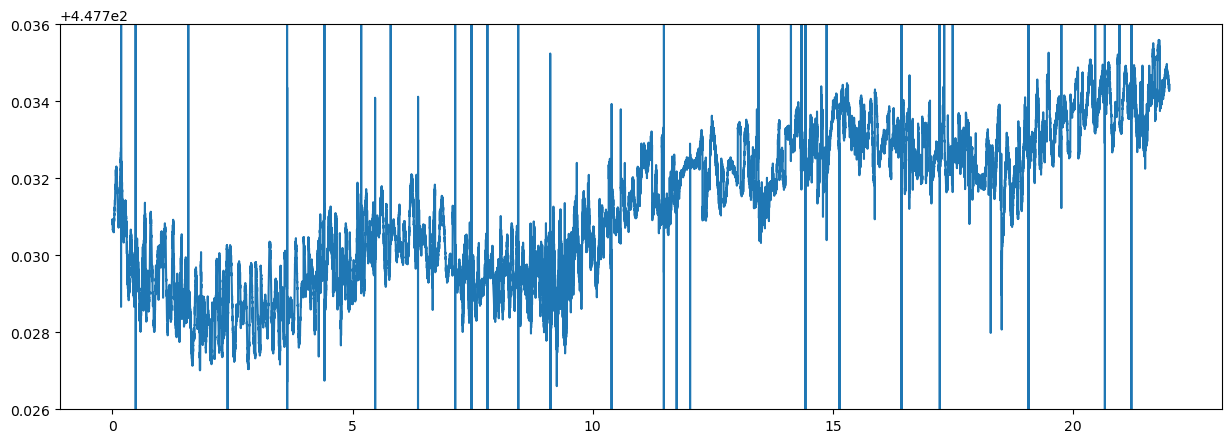

In [12]:
plt.figure(figsize=(15, 5))
plt.plot(bs.time_sec/86400, bs.fj_fs)
plt.ylim(flim1, flim2)

### Cut corrupt data periods

In [13]:
# times = [("2023-12-04T09:11", "2023-12-04T18:01")]

# for t1, t2 in times:
#     bs['fj_fs'] = np.where((bs.time1 > t1) & (bs.time1 < t2), np.nan, bs.fj_fs)
#     bs['fj_bs'] = np.where((bs.time1 > t1) & (bs.time1 < t2), np.nan, bs.w_s)


# bs['fj_fs'] = np.nan_to_num(bs['fj_fs'], nan=np.nanmedian(bs['fj_fs']))
# bs['fj_bs'] = np.nan_to_num(bs['fj_bs'], nan=np.nanmedian(bs['fj_bs']))

In [14]:
from functions.load_mlti import __load_mlti

mlti = __load_mlti(config['tbeg'], config['tend'], config['ring'], archive_path)

In [15]:
from functions.get_mlti_intervals import __get_mlti_intervals

mlti_t1, mlti_t2 = __get_mlti_intervals(mlti.time_utc)

In [16]:
from functions.mlti_intervals_to_NaN import __mlti_intervals_to_NaN

bs = __mlti_intervals_to_NaN(bs, "fj_fs", "time1", mlti_t1, mlti_t2, t_offset_sec=300)
bs = __mlti_intervals_to_NaN(bs, "fj_bs", "time1", mlti_t1, mlti_t2, t_offset_sec=300)

### Apply special filter sections

In [17]:
from functions.interpolate_nan import __interpolate_nan

bs['fj_fs_inter'] = __interpolate_nan(np.array(bs.fj_fs_nan))
bs['fj_bs_inter'] = __interpolate_nan(np.array(bs.fj_bs_nan))

In [18]:
from functions.smoothing import __smooth

n_minutes = 100

bs['fj_fs_smooth'] = __smooth(bs.fj_fs_inter, n_minutes)
bs['fj_bs_smooth'] = __smooth(bs.fj_bs_inter, n_minutes)

### Load LXX maintenance

In [19]:
from functions.load_lxx import __load_lxx

lxx =__load_lxx(config['tbeg'], config['tend'], archive_path)

In [20]:
from functions.get_lxx_intervals import __get_lxx_intervals

lxx_t1, lxx_t2 = __get_lxx_intervals(lxx.datetime)

### Checkup Plot

/tmp/ipykernel_790926/3069509830.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(tcklbls)


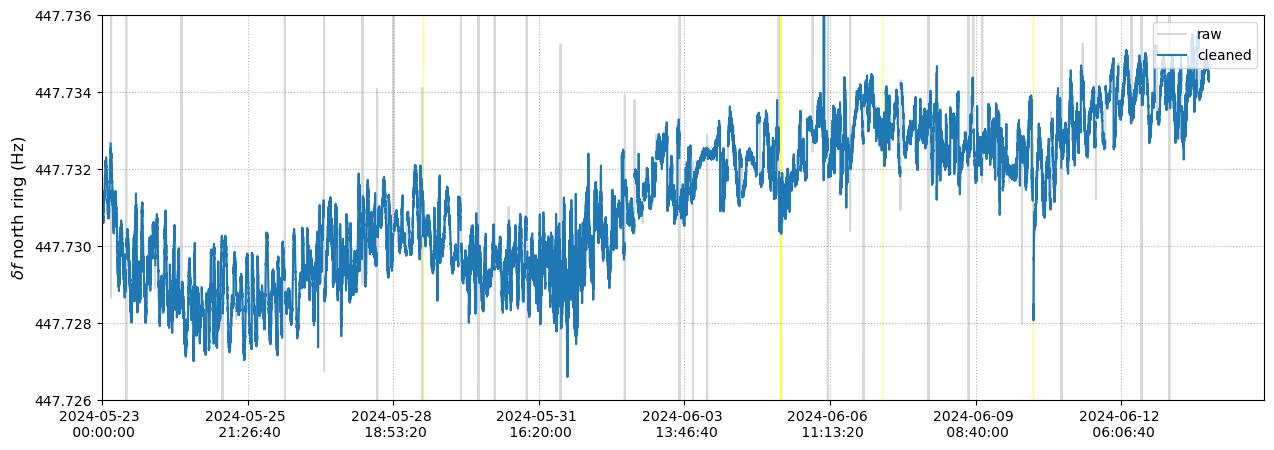

In [21]:
def __makeplot():

    Nrow, Ncol = 1, 1

    font = 12

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 5), sharex=True)

    plt.subplots_adjust(hspace=0.1)

    # time_scaling = 1/86400
    time_scaling = 1
    ref_date = str(bs.time1.iloc[0])[:10]

    ax.plot(bs.time_sec*time_scaling, bs.fj_fs, color="tab:grey", alpha=0.3, label="raw")
    ax.plot(bs.time_sec*time_scaling, bs.fj_fs_nan, color="tab:blue", label="cleaned")
    # ax.plot(bs.time_sec*time_scaling, bs.fj_fs_smooth, color="k", label=f"mov. avg. ({n_minutes} min)")
    ax.set_ylim(flim1, flim2)
    ax.ticklabel_format(useOffset=False)
    ax.set_ylabel("$\delta f$ north ring (Hz)", fontsize=font)

    ax.grid(ls=":", zorder=0)
    ax.legend(loc=1)
    ax.set_xlim(left=0)

    for lx1, lx2 in zip(lxx_t1, lxx_t2):
        lx1_sec = lx1-UTCDateTime(ref_date)
        lx2_sec = lx2-UTCDateTime(ref_date)
        ax.fill_betweenx([flim1, flim2], lx1_sec, lx2_sec, color="yellow", alpha=0.5)

    ## add dates to x-axis
    tcks = ax.get_xticks()
    tcklbls = [f"{UTCDateTime(UTCDateTime(ref_date)+t).date} \n {UTCDateTime(UTCDateTime(ref_date)+t).time}" for t in tcks]
    ax.set_xticklabels(tcklbls)

    gc.collect()

    plt.show();
    return fig

fig = __makeplot();

# fig.savefig(config['path_to_figs']+f"SF_BS_RU_longterm_cleaned.png", format="png", dpi=150, bbox_inches='tight')


### Load WROMY Data

In [22]:
# ws = Stream()
# ws += __read_sds(archive_path+"temp_archive/", "BW.WROMY.01.LKI", config['tbeg'], config['tend'])
# ws += __read_sds(archive_path+"temp_archive/", "BW.WROMY.05.LKI", config['tbeg'], config['tend'])
# ws += __read_sds(archive_path+"temp_archive/", "BW.WROMY.09.LKI", config['tbeg'], config['tend'])

# ws = ws.merge();

# ws

### Load PROMY Data

In [23]:
# ps = Stream()
# ps += __read_sds(archive_path+"temp_archive/", "BW.PROMY.03.LKI", config['tbeg'], config['tend'])
# ps += __read_sds(archive_path+"temp_archive/", "BW.PROMY.01.LKI", config['tbeg'], config['tend'])
# ps += __read_sds(archive_path+"temp_archive/", "BW.PROMY.05.LKI", config['tbeg'], config['tend'])
# ps += __read_sds(archive_path+"temp_archive/", "BW.PROMY.09.LKI", config['tbeg'], config['tend'])

# ps3 = ps.merge();

# ps

### Load RMY Pressure

6 Trace(s) in Stream:
BW.PROMY.03.LDI | 2024-05-23T00:00:00.000000Z - 2024-06-11T23:59:59.000000Z | 1.0 Hz, 1728000 samples
BW.ALFT..LDO    | 2024-05-23T00:00:00.000000Z - 2024-06-11T23:59:59.000000Z | 1.0 Hz, 1728000 samples
BW.TON..LDO     | 2024-05-23T00:00:00.000000Z - 2024-06-11T23:59:59.000000Z | 1.0 Hz, 1728000 samples
BW.BIB..LDO     | 2024-05-23T00:00:00.000000Z - 2024-06-11T23:59:59.000000Z | 1.0 Hz, 1728000 samples
BW.GELB..LDO    | 2024-05-23T00:00:00.000000Z - 2024-06-11T23:59:59.000000Z | 1.0 Hz, 1728000 samples
BW.GRMB..LDO    | 2024-05-23T00:00:00.000000Z - 2024-06-11T23:59:59.000000Z | 1.0 Hz, 1728000 samples
26 0.9624876825869016
-50 0.9779972293891134
92 0.9706050019954722
70 0.9765981967173345
68 0.9646316609153633


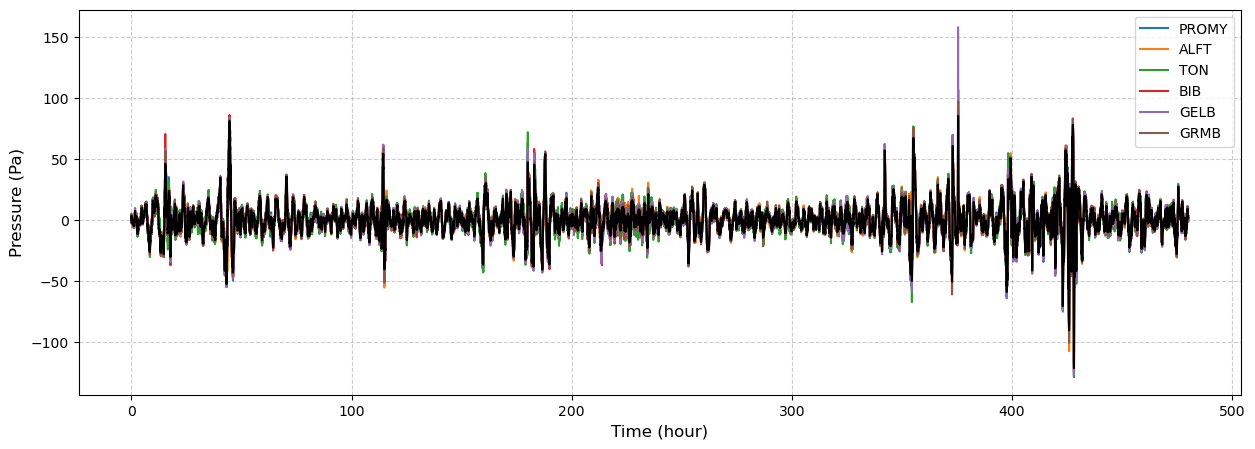

In [24]:
from functions.get_mean_rmy_pressure import __get_mean_rmy_pressure

# rmy = __get_mean_rmy_pressure(["PROMY", "ALFT", "TON", "BIB", "GELB", "GRMB"],
#                               config['tbeg'], config['tend'],
#                               archive_path,
#                               plot=True,
#                              )

### Load Tilt Data

In [25]:
from functions.conversion_to_tilt import __conversion_to_tilt

In [26]:
# path_to_tilt = data_path+"TiltmeterDataBackup/Tilt_downsampled/"

# tromy0 =  __read_sds(path_to_tilt, "BW.TROMY..MAN", config['tbeg']+17*86400-600, config['tend']+600)
# tromy0 += __read_sds(path_to_tilt, "BW.TROMY..MAE", config['tbeg']+17*86400-600, config['tend']+600)
# tromy0 += __read_sds(path_to_tilt, "BW.TROMY..MAT", config['tbeg']+17*86400-600, config['tend']+600)

path_to_tilt = archive_path+"romy_archive/"

tromy0 =  __read_sds(path_to_tilt, "BW.ROMYT..MAN", config['tbeg']-600, config['tend']+600)
tromy0 += __read_sds(path_to_tilt, "BW.ROMYT..MAE", config['tbeg']-600, config['tend']+600)
tromy0 += __read_sds(path_to_tilt, "BW.ROMYT..MAT", config['tbeg']-600, config['tend']+600)

  -> converted data of ROMYT


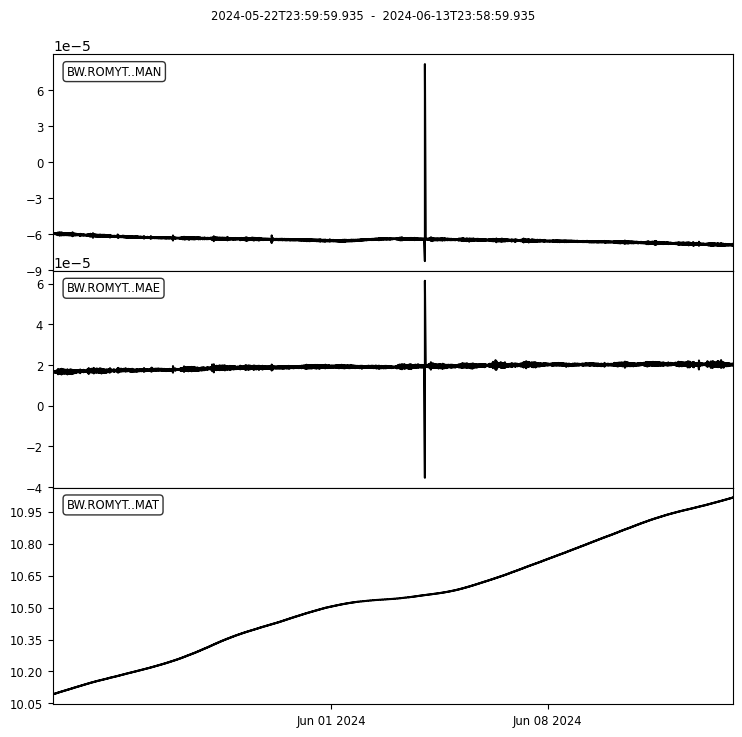

In [27]:
## tiltmeter configurations
confTilt = __readYaml(root_path+"Documents/ROMY/tiltmeter/", "tiltmeter.conf")

tromy0 = __conversion_to_tilt(tromy0, confTilt['TROMY'])

tromy0 = tromy0.trim(bs.time1[0], bs.time1[bs.time1.size-1]);

tromy = tromy0.copy();

tromy = tromy.merge();

tromy.plot(equal_scale=False);

In [28]:
vectorV = [np.cos(np.deg2rad(30)), np.sin(np.deg2rad(30)), np.cos(np.deg2rad(70.5))]
vectorV_norm = np.sqrt(vectorV[0]**2+vectorV[1]**2+vectorV[2]**2)

In [29]:
vectorV_norm

1.0542423911375953

<bound method Vector.norm of Vector([0.8660254 , 0.5       , 0.33380686])>


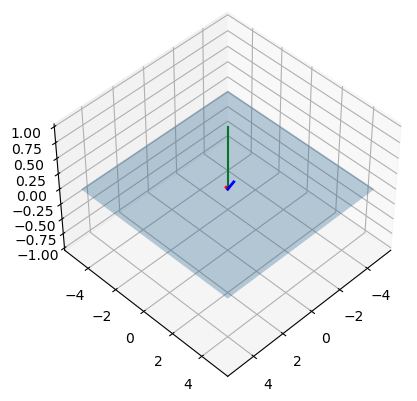

In [30]:
from skspatial.objects import Plane, Vector
from skspatial.plotting import plot_3d

normal = Vector([0, 0, 1])
plane = Plane([0, 0, 0], [0, 0, 1])
vectorV = Vector([np.cos(np.deg2rad(30)), np.sin(np.deg2rad(30)), np.cos(np.deg2rad(70.5))])
vectorW = Vector([-np.cos(np.deg2rad(30)), np.sin(np.deg2rad(30)), np.cos(np.deg2rad(70.5))])

vectorV_projected = vectorV.project_vector(normal)
vectorW_projected = vectorW.project_vector(normal)

print(vectorV.norm)

_, ax = plot_3d(
    plane.plotter(lims_x=(-5, 5), lims_y=(-5, 5), alpha=0.3),
    # vector.plotter(point=plane.point, color='k'),
    normal.plotter(point=plane.point, color='g'),
    vectorV_projected.plotter(point=plane.point, color='r', linewidth=2, zorder=3),
    vectorW_projected.plotter(point=plane.point, color='b', linewidth=2, zorder=3),

)

ax.set_zlim([-1, 1])
ax.view_init(elev=45, azim=45, roll=0)

In [108]:
def __sagnac_to_tilt(data=None, ring="Z", tilt="n-s"):

    from numpy import pi, sqrt, arccos, deg2rad, arcsin, cos, sin

    # angle in horizontal plane
    h_rot = {"Z":0, "U":0, "V":60, "W":60}

    # angle from vertical
    v_rot = {"Z":0, "U":109.5, "V":70.5, "W":70.5}

    # dip = {"Z":0, "U":-70.5-180, "V":-14, "W":-14}

    # side length
    L = {"Z":11.2, "U":12, "V":12, "W":12}

    # Scale factor
    S = (sqrt(3)*L[ring])/(3*632.8e-9)

    #ROMY latitude
    lat = np.deg2rad(48.162941)
    lon = np.deg2rad(11.275501)

    # nominal Earth rotation
    omegaE = 2*pi/86400 * np.array([0, 0, 1])


    # matrix 1
    D = np.array([[-sin(lat)*cos(lon), -sin(lon), cos(lat)*cos(lon)],
                  [sin(lat)*sin(lon), cos(lon), cos(lat)*sin(lon)],
                  [cos(lat), 0, sin(lat)]
                 ])

    # tilt
    da = np.deg2rad(0)
    dz = np.deg2rad(0)

    # tilt matrix
    R = np.array([[1, -da, -dz], [da,  1, 0], [dz, 0, 1]])

    p1 = np.deg2rad(v_rot[ring])
    p2 = np.deg2rad(h_rot[ring])

    # normal vector of ring
    nx = np.array([[sin(p1)*cos(p2)], [sin(p1)*sin(p2)], [cos(p1)]])

    # terms
    term1 = cos(v_rot[ring])*sin(lat)
    term2 = cos(lat)*sin(v_rot[ring])*cos(h_rot[ring])

    # tilt factor
    fz = sin(lat)*sin(v_rot[ring])*cos(h_rot[ring]) - cos(v_rot[ring])*cos(lat)
    fa = sin(v_rot[ring])*sin(h_rot[ring])*cos(lat)

    if data is None:
        out = S * ( omegaE @ ( D @ (R @ nx) ) )[0]

    else:
        if tilt == "n-s":
            out = ( (data /S /omegaE[2]) - term1 - term2 ) / fz
        elif tilt == "e-w":
            out = ( (data /S /omegaE[2]) - term1 - term2 ) / fa


    return out

In [95]:
# from numpy import sin, cos

# lat = np.deg2rad(48.162941)
# lon = np.deg2rad(11.2)

# D = np.array([[-sin(lat)*cos(lon), -sin(lon), cos(lat)*cos(lon)],
#               [sin(lat)*sin(lon), cos(lon), cos(lat)*sin(lon)],
#               [cos(lat), 0, sin(lat)]
#              ])

# da = 0
# dz = 0

# R = np.array([[1, -da, -dz], [da,  1, 0], [dz, 0, 1]])

# omega_z = np.array([0, 0, 1])

# # V
# p1v = np.deg2rad(70.5)
# p2v = np.deg2rad(60.0)
# nv = np.array([[sin(p1v)*cos(p2v)], [sin(p1v)*sin(p2v)], [cos(p1v)]])

# Sv = (2*np.pi)/86400*(np.sqrt(3)*12.0)/(3*632.8e-9)

# v = Sv * ( omega_z @ ( D @ (R @ nv) ) )[0]

# # Z
# p1z = np.deg2rad(0)
# p2z = np.deg2rad(0)
# nz = np.array([[sin(p1z)*cos(p2z)], [sin(p1z)*sin(p2z)], [cos(p1z)]])

# Sz = (2*np.pi)/86400*(np.sqrt(3)*11.2)/(3*632.8e-9)

# z = Sz * ( omega_z @ ( D @ (R @ nz) ) )[0]

# # N
# p1n = np.deg2rad(109.5)
# p2n = np.deg2rad(0)
# nn = np.array([[sin(p1n)*cos(p2n)], [sin(p1n)*sin(p2n)], [cos(p1n)]])

# Sn = (2*np.pi)/86400*(np.sqrt(3)*12.0)/(3*632.8e-9)

# n = Sn * ( omega_z @ ( D @ (R @ nn) ) )[0]

# print(z, v ,n)

In [289]:
dff = np.array(bs.fj_bs_inter)

rx_tilt = __sagnac_to_tilt(dff, config['ring'], tilt="n-s")
# rx_tilt = __sagnac_to_tilt(dff, config['ring'], tilt="e-w")

rx = Stream()

rx = Trace()
rx.data = __interpolate_nan(__smooth(rx_tilt, 180))
rx.stats.delta = 60
rx.stats.starttime = bs.time1.iloc[0]
rx.stats.station = "ROMY"
rx.stats.channel = f"FJ{config['ring']}"
rx.stats.network = "BW"


In [290]:
st0 = Stream()

st0 += tromy.copy().select(channel="*N")[0]
st0 += tromy.copy().select(channel="*E")[0]

st0 += rx.copy()

In [291]:
pmin, pmax = 13, 11

st0 = st0.trim(config['tbeg'], config['tend'], nearest_sample=False)
st0 = st0.detrend("linear")
st0 = st0.taper(0.2)
st0 = st0.filter("bandpass", freqmin=1/(pmin*3600), freqmax=1/(pmax*3600), corners=2, zerophase=True)
st0 = st0.resample(1/600, no_filter=True)
st0 = st0.trim(config['tbeg'], config['tend']-7200, nearest_sample=True)
st0


3 Trace(s) in Stream:
BW.ROMYT..MAN | 2024-05-23T00:00:00.135000Z - 2024-06-13T22:00:00.135000Z | 600.0 s, 3157 samples
BW.ROMYT..MAE | 2024-05-23T00:00:00.135000Z - 2024-06-13T22:00:00.135000Z | 600.0 s, 3157 samples
BW.ROMY..FJV  | 2024-05-23T00:00:00.000000Z - 2024-06-13T22:00:00.000000Z | 600.0 s, 3157 samples

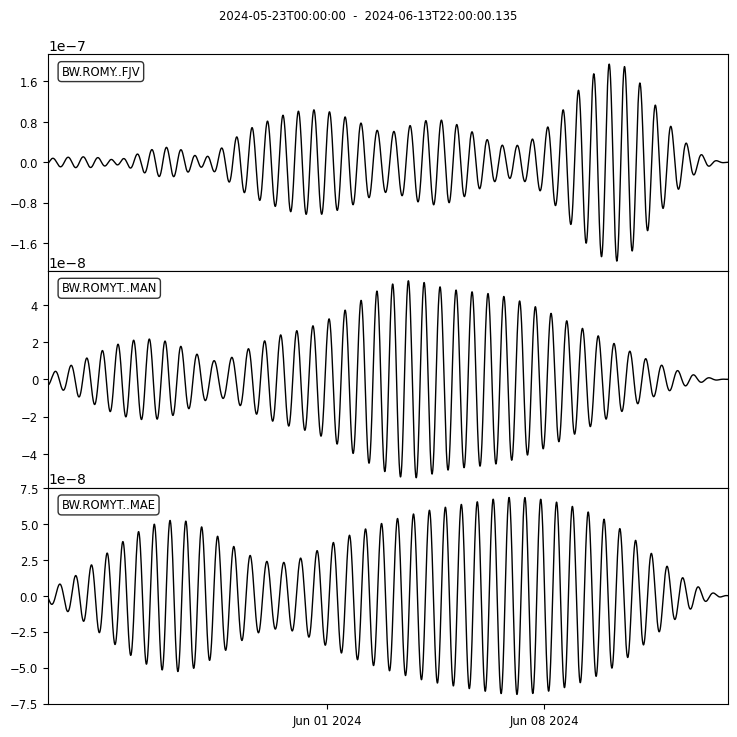

In [292]:
st0.plot(equal_scale=False);

In [293]:

outs = {}

for c in ["N", "E", config['ring']]:

    tr = st0.select(channel=f"*{c}")[0]

    ttt = tr.times()
    arr = tr.data
    dt = tr.stats.delta # seconds

    outs[c] = __compute_cwt(ttt, arr, dt,
                            tscale="hour",
                            datalabel="$\delta$f (Hz)",
                            scale_value=2,
                            log=False, period=True, ymax=30, plot=False,
                           )


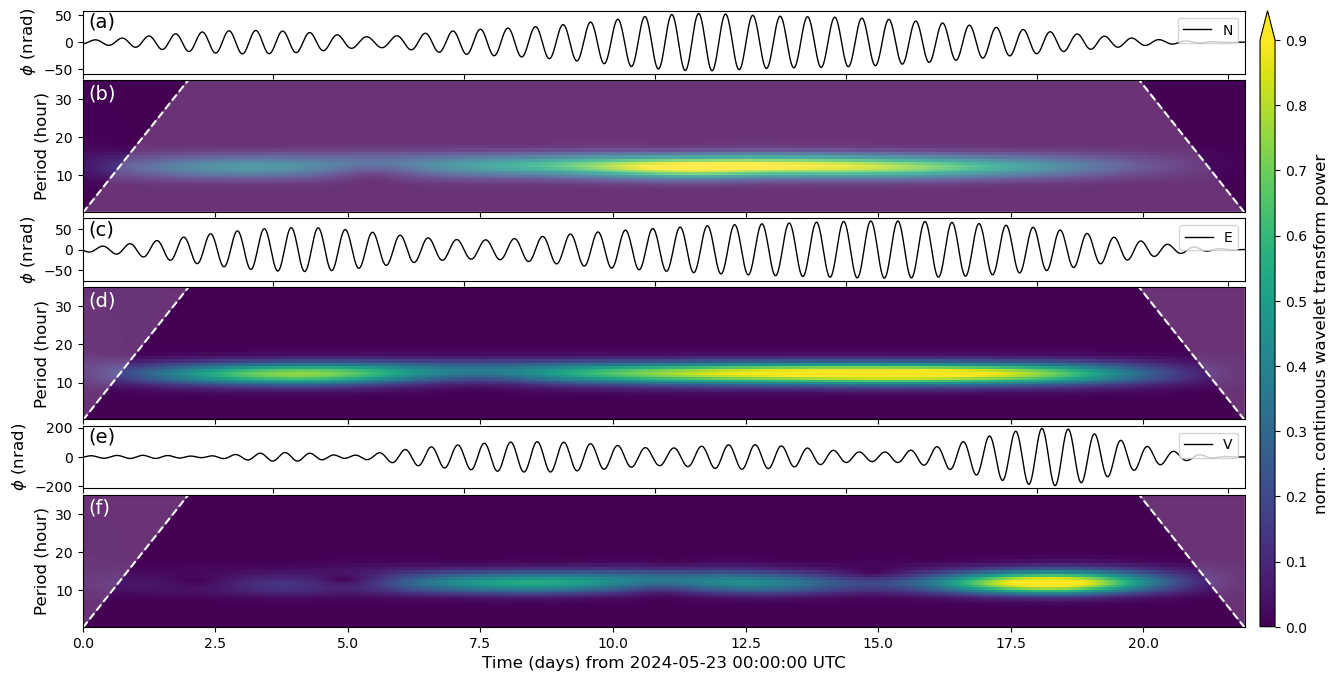

In [294]:
def __makeplot_cwt_all(st0, out, clog=False, ylim=None):

    import matplotlib.pyplot as plt
    import numpy as np
    from matplotlib.gridspec import GridSpec

    def __rmse(arr1, arr2):
        return np.round(np.sqrt(np.mean((arr1-arr2)**2)), 2)

    tscale = 1/86400

    times = st0.select(channel="*N")[0].times()*tscale/3600

    Ncol, Nrow = 1, 9

    font = 12

    cmap = plt.get_cmap("viridis")

    tilt_scale, tilt_unit = 1e9, f"nrad"

    fig = plt.figure(figsize=(15, 8))

    gs = GridSpec(Nrow, Ncol, figure=fig, hspace=0.1)

    ax1 = fig.add_subplot(gs[0, :])
    ax2 = fig.add_subplot(gs[1:3, :])
    ax3 = fig.add_subplot(gs[3, :])
    ax4 = fig.add_subplot(gs[4:6, :])
    ax5 = fig.add_subplot(gs[6, :])
    ax6 = fig.add_subplot(gs[7:9, :])

    axes = [ax1, ax2, ax3, ax4, ax5, ax6]

    U = st0.select(channel=f"*{config['ring']}")[0].data*tilt_scale
    N = st0.select(channel="*N")[0].data*tilt_scale
    E = st0.select(channel="*E")[0].data*tilt_scale

    periodZ = 1/outs[config['ring']]['frequencies']/3600
    periodN = 1/outs['N']['frequencies']/3600
    periodE = 1/outs['N']['frequencies']/3600

    # _______________________________________________________________
    #
    ax1.plot(times, N, color="k", label="N", lw=1)
    ax1.set_xlim(min(times), max(times))
    ax1.legend(loc=1)
    ax1.set_xticklabels([])

    if clog:
        vmin, vmax, norm = 0.01, 1, "log"
    else:
        vmin, vmax, norm = 0.0, 0.9, None
    # _______________________________________________________________
    #
    im1 = ax2.pcolormesh(out['N']['times']*tscale*3600, periodN, out['N']['cwt_power'],
                         cmap=cmap,
                         vmin=vmin,
                         vmax=vmax,
                         norm=norm,
                        )
    ax2.plot(out['N']['times']*tscale*3600, 1/out['N']['cone']/3600, color="white", ls="--")
    ax2.fill_between(out['N']['times']*tscale*3600, 1/out['N']['cone']/3600, min(periodN)*np.ones(len(out['N']['cone'])), color="white", alpha=0.2)
    ax2.set_xticklabels([])

    if ylim is None:
        ax2.set_ylim(min(periodN), max(periodN))
    else:
        ax2.set_ylim(min(periodN), ylim)

    # _______________________________________________________________
    #
    ax3.plot(times, E, color="k", label="E", lw=1)
    ax3.set_xlim(min(times), max(times))
    ax3.legend(loc=1)
    ax3.set_xticklabels([])

    # _______________________________________________________________
    #
    im2 = ax4.pcolormesh(out['E']['times']*tscale*3600, periodE, out['E']['cwt_power'],
                         cmap=cmap,
                         vmin=vmin,
                         vmax=vmax,
                         norm=norm,
                        )
    ax4.plot(out['E']['times']*tscale*3600, 1/out['E']['cone']/3600, color="white", ls="--")
    ax4.fill_between(out['E']['times']*tscale*3600, 1/out['E']['cone']/3600, max(periodE)*np.ones(len(out['E']['cone'])), color="white", alpha=0.2)
    ax4.set_xticklabels([])

    if ylim is None:
        ax4.set_ylim(min(periodE), max(periodE))
    else:
        ax4.set_ylim(min(periodE), ylim)

    # _______________________________________________________________
    #
    ax5.plot(times, U, color="k", label=config['ring'], lw=1)
    ax5.set_xlim(min(times), max(times))
    ax5.legend(loc=1)
    ax5.set_xticklabels([])

    # _______________________________________________________________
    #
    im3 = ax6.pcolormesh(out[config['ring']]['times']*tscale*3600, periodE, out[config['ring']]['cwt_power'],
                         cmap=cmap,
                         vmin=vmin,
                         vmax=vmax,
                         norm=norm,
                        )
    ax6.plot(out[config['ring']]['times']*tscale*3600, 1/out[config['ring']]['cone']/3600, color="white", ls="--")
    ax6.fill_between(out[config['ring']]['times']*tscale*3600, 1/out[config['ring']]['cone']/3600, max(periodZ)*np.ones(len(out[config['ring']]['cone'])), color="white", alpha=0.2)

    if ylim is None:
        ax6.set_ylim(min(periodZ), max(periodZ))
    else:
        ax6.set_ylim(min(periodZ), ylim)

    # _______________________________________________________________
    #
    ax1.set_ylabel(f"$\phi$ ({tilt_unit})", fontsize=font)
    ax2.set_ylabel(f"Period (hour)", fontsize=font)
    ax3.set_ylabel(f"$\phi$ ({tilt_unit})", fontsize=font)
    ax4.set_ylabel(f"Period (hour)", fontsize=font)
    ax5.set_ylabel(f"$\phi$ ({tilt_unit})", fontsize=font)
    ax6.set_ylabel(f"Period (hour)", fontsize=font)

    ax6.set_xlabel(f"Time (days) from {config['tbeg'].date} {str(config['tbeg'].time).split('.')[0]} UTC", fontsize=font)


    ax1.text(.005, .97, "(a)", ha='left', va='top', transform=ax1.transAxes, fontsize=font+2)
    ax2.text(.005, .97, "(b)", ha='left', va='top', transform=ax2.transAxes, fontsize=font+2, color="w")
    ax3.text(.005, .97, "(c)", ha='left', va='top', transform=ax3.transAxes, fontsize=font+2)
    ax4.text(.005, .97, "(d)", ha='left', va='top', transform=ax4.transAxes, fontsize=font+2, color="w")
    ax5.text(.005, .97, "(e)", ha='left', va='top', transform=ax5.transAxes, fontsize=font+2)
    ax6.text(.005, .97, "(f)", ha='left', va='top', transform=ax6.transAxes, fontsize=font+2, color="w")

    # add colorbar
    cbar_ax = fig.add_axes([0.91, 0.11, 0.01, 0.77]) #[left, bottom, width, height]
    cb = plt.colorbar(im1, cax=cbar_ax, extend="max")
    cb.set_label("norm. continuous wavelet transform power", fontsize=font, labelpad=5, color="black")

#     ax1.set_title(f"bandpass = {pmax} - {pmin} hours")

    plt.plot();
    return fig

fig = __makeplot_cwt_all(st0, outs, clog=False, ylim=35)

fig.savefig(config['path_to_figs']+f"SF_BS_RV_CWT_tilt.png", format="png", dpi=150, bbox_inches='tight')


### Compute Predicted Tilt

In [295]:
def __get_tides(tbeg, tend, component="N", typ="acc", df=3600):

    from pygtide import predict_series
    from numpy import arange, pi
    from obspy import UTCDateTime

    # ROMY
    lat = 48.162941
    lon = 11.275501
    height = 570

    startdate = str(UTCDateTime(tbeg).date)
    duration =  (UTCDateTime(tend) -  UTCDateTime(tbeg)) /3600 # in hours
    sampling_rate = df # in seconds

    # creat time vector
    times = arange(0, duration+df/3600, df/3600)

    # prepare arguments
    args = (lat, lon, height, startdate, duration, sampling_rate)

    # specify station azimuth clockwise from north (=0)
    if component == "N":
        statazimut = 0
    elif component == "E":
        statazimut = 90



    if typ == "rad":
        # tides /= 9.81
        tides = predict_series(*args, statgravit=0, statazimut=statazimut, tidalcompo=1) # tilt

        # from mas to rad
        tides = tides * pi / 648000000

    elif typ == "acc":
        tides = predict_series(*args, statazimut=statazimut, tidalcompo=0) # horizontal acceleration

        # from nano to acc
        tides *= 1e-9

    elif typ == "str":
        tides = predict_series(*args, statazimut=statazimut, tidalcompo=5) # horizontal strain

        # from nano to str
        tides *= 1e9

    return times, tides

In [296]:
# predict tidal tilts
times, tideN = __get_tides(config['tbeg'], config['tend']-1, component="N", typ="rad", df=3600)
times, tideE = __get_tides(config['tbeg'], config['tend']-1, component="E", typ="rad", df=3600)


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/pygtide/core.py:348: UserWarning: Please consider updating the leap second database 'b'etddt.dat        '' (last value is from 2017-01-01 00:00:00).
  warn("Please consider updating the leap second database '%s' (last value is from %s)." % (fname, self.etddt_end))
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/pygtide/core.py:352: UserWarning: Dates exceed permissible range for pole/LOD tide correction (interval 1962-01-01 00:00:00 to 2023-06-10 00:00:00). Consider update file 'b'etddt.dat        ''.
  warn("Dates exceed permissible range for pole/LOD tide correction (interval %s to %s). Consider update file '%s'." % (self.etpolut1_start, self.etpolut1_end, fname))


In [297]:
gtide = Stream()

gtideN = Trace()
gtideN.data = tideN
gtideN.stats.delta = 3600
gtideN.stats.starttime = config['tbeg']
gtideN.stats.station = "GTID"
gtideN.stats.channel = "LAN"
gtideN.stats.network = "BW"

gtideE = Trace()
gtideE.data = tideE
gtideE.stats.delta = 3600
gtideE.stats.starttime = config['tbeg']
gtideE.stats.station = "GTID"
gtideE.stats.channel = "LAE"
gtideE.stats.network = "BW"

gtide += gtideE
gtide += gtideN

### Make Collective Stream

5 Trace(s) in Stream:
BW.ROMY..FJV  | 2024-05-23T00:00:00.000000Z - 2024-06-13T22:42:00.000000Z | 4140.0 s, 459 samples
BW.GTID..LAE  | 2024-05-23T00:00:00.000000Z - 2024-06-13T22:42:00.000000Z | 4140.0 s, 459 samples
BW.GTID..LAN  | 2024-05-23T00:00:00.000000Z - 2024-06-13T22:42:00.000000Z | 4140.0 s, 459 samples
BW.ROMYT..MAN | 2024-05-23T00:00:00.135000Z - 2024-06-13T22:42:00.135000Z | 4140.0 s, 459 samples
BW.ROMYT..MAE | 2024-05-23T00:00:00.135000Z - 2024-06-13T22:42:00.135000Z | 4140.0 s, 459 samples


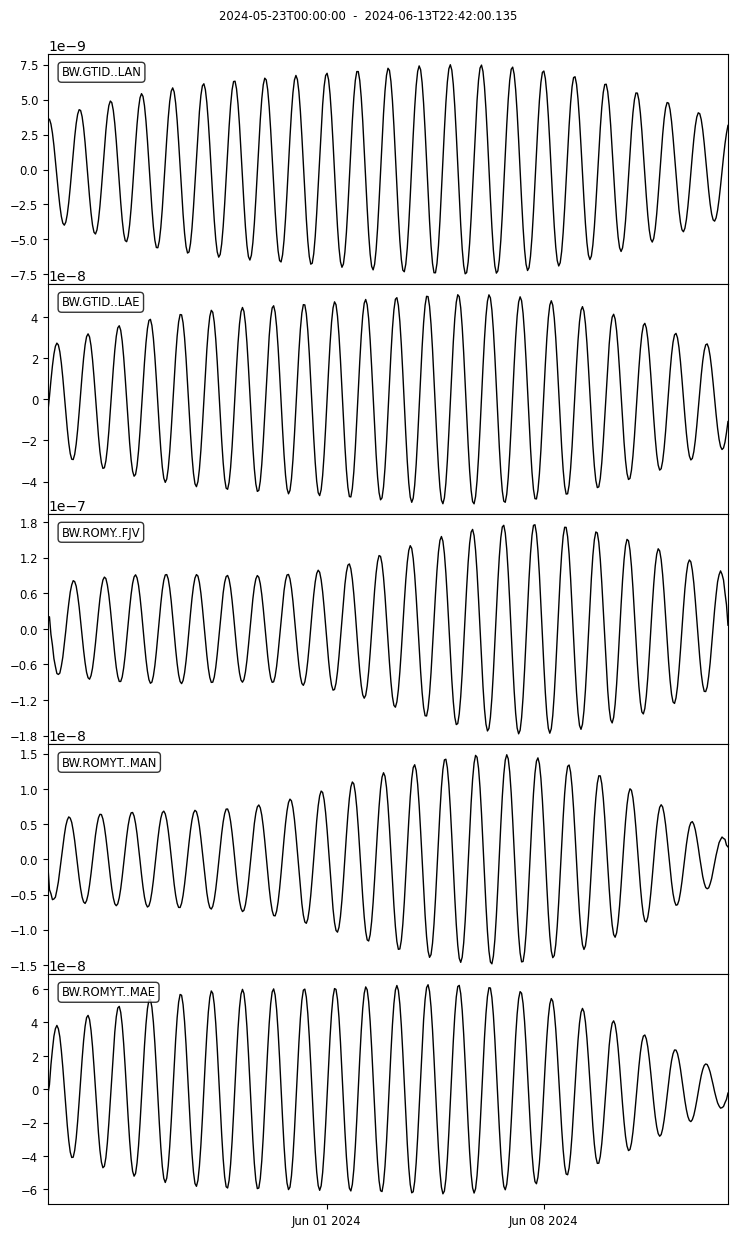

In [312]:
fmin, fmax, tide_str = 1/(25*3600), 1/(23*3600), "24hr"
# fmin, fmax, tide_str = 1/(13*3600), 1/(11*3600), "12hr"

stt = Stream()

# stt += rx.copy().integrate("spline")
stt += rx.copy()
stt += gtide.copy()
# stt += rmy.copy()
stt += tromy.select(component="N").copy()
stt += tromy.select(component="E").copy()

stt = stt.trim(config['tbeg'], config['tend'], nearest_sample=False)

stt = stt.detrend("demean")
stt = stt.detrend("simple")

stt = stt.taper(0.05, type="cosine")

NN = 1_000_000
for tr in stt:
    tr.data = np.pad(tr.data, (NN, NN), 'constant')

stt = stt.taper(0.2, type="cosine")

stt = stt.filter("bandpass", freqmin=fmin, freqmax=fmax, corners=2, zerophase=True)

for tr in stt:
    tr.data = tr.data[NN:-NN]

stt = stt.resample(20*fmax, no_filter=True)

print(stt)

stt.plot(equal_scale=False);

In [308]:
# for tr in stt:
#     if tr.stats.channel == "FJV":
#         tr.data = tr.data[:-1]

### Fit Models

In [313]:
def __estimate_linear_coefficients(st0, c1="V", c2="N", c3="E"):

    from scipy.signal import hilbert
    from numpy import imag, array, linalg, vstack


    # data1
    pp = st0.select(channel=c2)[0].data

    # data2
    hp = st0.select(channel=c3)[0].data

    # data
    dd = st0.select(channel=c1)[0].data

    # matrix
    A = vstack([pp, hp]).T

    # least squares
    a, b = linalg.lstsq(A, dd, rcond=None)[0]

    # estimate of data
    hh = a*pp + b*hp

    # residual
    rr = dd - hh

    return a, b, hh, rr

In [314]:
def __estimate_linear_coefficients_pressure(st0, c1="N", c2="O", c3=None):

    from scipy.signal import hilbert
    from numpy import imag, array, linalg, vstack

    if c3 is None:
        c3 = c2

    # pressure
    pp = st0.select(channel=c2)[0].data

    # hilbert(pressure)
    hp = imag(hilbert(st0.select(channel=c3)[0].data))

    # data
    dd = st0.select(channel=c1)[0].data

    # matrix
    A = vstack([pp, hp]).T

    # least squares
    a, b = linalg.lstsq(A, dd, rcond=None)[0]

    # estimate of data
    hh = a*pp + b*hp

    # residual
    rr = dd - hh

    return a, b, hh, rr

In [315]:
t0, dat0 = stt.select(component="E")[0].times(reftime=config['tbeg']), stt.select(component="E")[0].data
t1, dat1 = stt.select(component="N")[0].times(reftime=config['tbeg']), stt.select(component="N")[0].data

t2, dat2 = stt.select(component="V")[0].times(reftime=config['tbeg']), stt.select(component="V")[0].data

# t3, dat3 = stt.select(component="O")[0].times(reftime=config['tbeg']), stt.select(component="O")[0].data

t4, dat4 = stt.select(station="ROMYT", channel="*E")[0].times(reftime=config['tbeg']), stt.select(station="ROMYT", channel="*E")[0].data
t5, dat5 = stt.select(station="ROMYT", channel="*N")[0].times(reftime=config['tbeg']), stt.select(station="ROMYT", channel="*N")[0].data


dat2_mod = dat2*-1

# fit barometer data to make model
# a_p, b_p, mod_p, res_p = __estimate_linear_coefficients_pressure(stt, c1="FJV", c2="LDO", c3="LDO")

# make residual to data
# stt.select(component="V")[0].data = res_p

# model tilt with tilt model
a_t, b_t, mod_t, res_t = __estimate_linear_coefficients(stt, c1="FJV", c2="LAN", c3="LAE")
a_o, b_o, mod_o, res_o = __estimate_linear_coefficients(stt, c1="FJV", c2="MAN", c3="MAE")



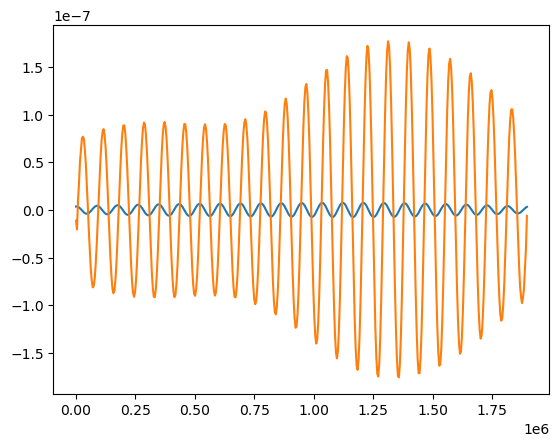

In [316]:
plt.plot(t1, dat1)

plt.plot(t2, dat2_mod)


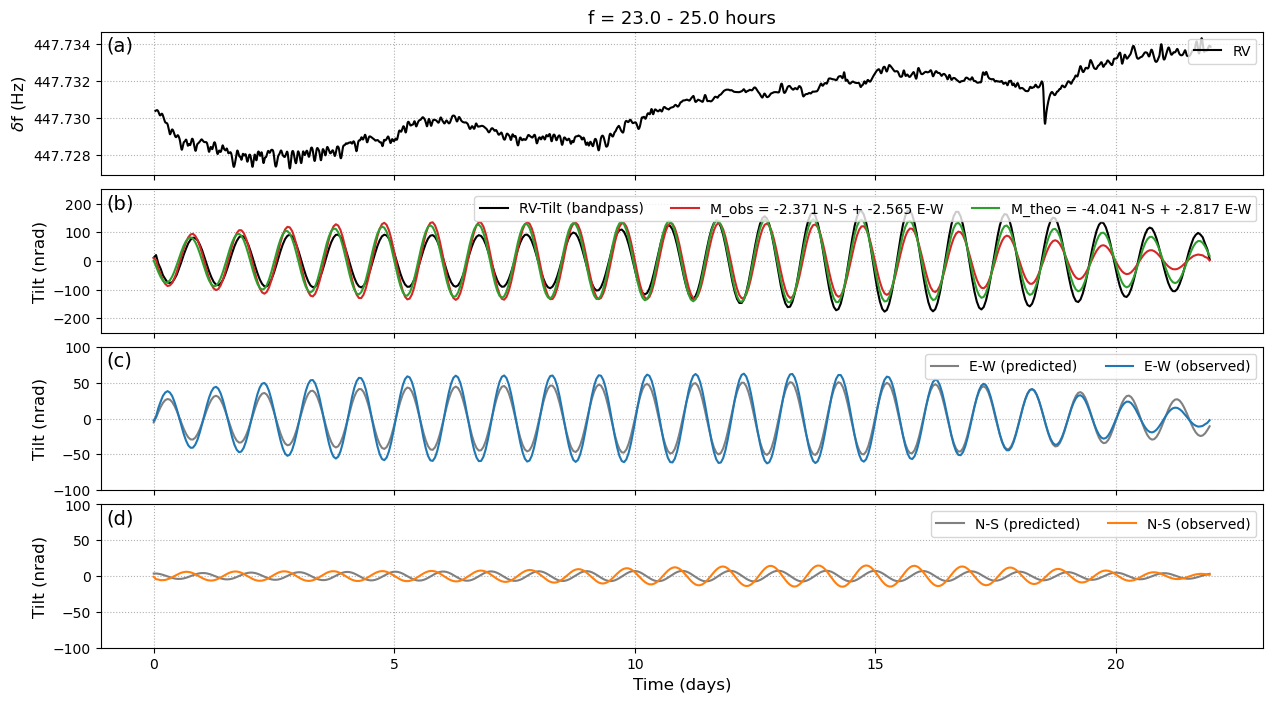

In [317]:
def __makeplot():

    Nrow, Ncol = 4, 1

    font = 12

    tscale, tunit = 1/86400, "days"

    tiltscale, tiltunit = 1e9, "nrad"

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 8), sharex=True)

    plt.subplots_adjust(hspace=0.1)

    ax[0].plot(bs.time_sec*tscale, bs.fj_bs_smooth, label="RV", color="k")
    # ax[0].set_ylim(flim1, flim2)
    ax[0].ticklabel_format(useOffset=False)
    ax[0].set_ylabel(r"$\delta$f (Hz)", fontsize=font)

    ax[1].plot(t2*tscale, dat2*tiltscale, color="k", label="RV-Tilt (bandpass)")
    ax[1].plot(t2*tscale, mod_o*tiltscale, color="tab:red", label=f"M_obs = {a_o:.3f} N-S + {b_o:.3f} E-W")
    ax[1].plot(t2*tscale, mod_t*tiltscale, color="tab:green", label=f"M_theo = {a_t:.3f} N-S + {b_t:.3f} E-W")
    # ax[1].plot(t2*tscale, res*tiltscale, color="tab:red", label=f"{a:.3f} N-S + {b:.3f} E-W")
    ax[1].set_ylabel(f"Tilt ({tiltunit})", fontsize=font)

    ax[2].plot(t0*tscale, dat0*tiltscale, label="E-W (predicted)", color="grey")
    ax[2].plot(t4*tscale, dat4*tiltscale, label="E-W (observed)", color="tab:blue")
    ax[2].set_ylabel(f"Tilt ({tiltunit})", fontsize=font)

    ax[3].plot(t1*tscale, dat1*tiltscale, label="N-S (predicted)", color="grey")
    ax[3].plot(t5*tscale, dat5*tiltscale, label="N-S (observed)", color="tab:orange")
    ax[3].set_ylabel(f"Tilt ({tiltunit})", fontsize=font)

    ax[3].set_xlabel(f"Time ({tunit})", fontsize=font)

    ax[0].set_title(f"f = {1/fmax/3600} - {1/fmin/3600} hours", fontsize=font+1)

    ax[1].set_ylim(-250, 250)
    ax[2].set_ylim(-100, 100)
    ax[3].set_ylim(-100, 100)

    for _k, ll in enumerate(['(a)', '(b)', '(c)', '(d)']):
        ax[_k].text(.005, .97, ll, ha='left', va='top', transform=ax[_k].transAxes, fontsize=font+2)

    for _n in range(Nrow):
        ax[_n].grid(ls=":", zorder=0)
        ax[_n].legend(loc=1, ncol=3)

    plt.show();
    return fig

fig = __makeplot();

fig.savefig(config['path_to_figs']+f"SF_BS_RV_tilt_tides_{tide_str}.png", format="png", dpi=150, bbox_inches='tight')


In [ ]:
def __makeplot():

    Nrow, Ncol = 4, 1

    font = 12

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 8))

    ax[0].plot(t0, dat0, label="E", color="tab:blue")
    ax[0].plot(t1, dat1, label="N", color="tab:orange")
    ax[0].plot(t2, dat2_mod, color="k")

    ax[1].plot(t2, dat2*-1, color="k")
    ax[1].plot(t2, res_p*-1, color="tab:red")

    ax[2].plot(t0, dat0, label="E", color="tab:blue")
    ax[2].plot(t1, dat1, label="N", color="tab:orange")
    ax[2].plot(t2, res_p*-1, color="tab:red")

    ax[3].plot(t2, dat2, color="k")
    ax[3].plot(t2, mod, color="tab:green")

    for _n in range(Nrow):
        ax[_n].grid(ls=":", zorder=0)
        ax[_n].legend(loc=1)

    plt.show();
    return fig

# fig = __makeplot();


In [ ]:
def __compare_tilt_pressure(st0):

    from obspy.signal.cross_correlation import correlate, xcorr_max
    from numpy import nan_to_num, arange, array, linspace, imag, roll
    from matplotlib.gridspec import GridSpec
    from functions.compute_orthogonal_distance_regression import __compute_orthogonal_distance_regression
    from functions.smoothing import __smooth
    from scipy.signal import hilbert

    tlp = st0.copy()

    dt = tlp[0].stats.delta

    times = tlp[0].times()/3600

    ch = "FJV"

    arr0 = tlp.select(channel=ch)[0].data
    arr1 = tlp.select(component="N")[0].data
    arr2 = tlp.select(component="E")[0].data


    Nshift = len(arr0)

    ccf1 = correlate(arr0, arr1, shift=Nshift, demean=False, normalize='naive', method='fft')
    ccf2 = correlate(arr0, arr2, shift=Nshift, demean=False, normalize='naive', method='fft')

    cclags = arange(-Nshift, Nshift+1) * dt

    shift1, value1 = xcorr_max(ccf1)
    shift2, value2 = xcorr_max(ccf2)

    arr1_shifted = roll(arr1, shift1)
    arr2_shifted = roll(arr2, shift2)

    print("Nshift: ", shift1, "Tshift: ", shift1*dt, "CC: ", value1)
    print("Nshift: ", shift2, "Tshift: ", shift2*dt, "CC: ", value2)


    b1, a1 = __compute_orthogonal_distance_regression(arr0, arr1, xerr=None, yerr=None, bx=None, by=None)
    b2, a2 = __compute_orthogonal_distance_regression(arr0, arr2, xerr=None, yerr=None, bx=None, by=None)

    b1_shifted, a1_shifted = __compute_orthogonal_distance_regression(arr0, arr1_shifted, xerr=None, yerr=None, bx=None, by=None)
    b2_shifted, a2_shifted = __compute_orthogonal_distance_regression(arr0, arr2_shifted, xerr=None, yerr=None, bx=None, by=None)

    xxx = linspace(arr0.min(), arr0.max(), 100)

    Nrow, Ncol = 5, 2
    font = 12

    fig = plt.figure(figsize=(12, 10))

    gs0 = GridSpec(Nrow, Ncol, figure=fig, hspace=0)
    gs = GridSpec(Nrow, Ncol, figure=fig, hspace=0.5)

    ax1 = fig.add_subplot(gs0[0, :])
    ax2 = fig.add_subplot(gs[1, :])
    ax3 = fig.add_subplot(gs[2, :1])
    ax4 = fig.add_subplot(gs[2, 1:])
    ax5 = fig.add_subplot(gs[3, :1])
    ax6 = fig.add_subplot(gs[3, 1:])
    ax7 = fig.add_subplot(gs[4, :1])
    ax8 = fig.add_subplot(gs[4, 1:])

    axes = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8]
    for _k, (ax, ll) in enumerate(zip(axes, ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)', '(h)'])):
        ax.text(.005, .97, ll, ha='left', va='top', transform=ax.transAxes, fontsize=font+2)

    plt.subplots_adjust(hspace=0.35)

    ax1.plot(times, arr0, color="black", label=f"FFBI.{ch}")
    ax1.set_ylabel("Pressure (Pa)", fontsize=font)
    ax1.get_xaxis().set_visible(False)
    ax1.legend(loc=1)

    ax2.plot(times, arr1*1e9, label="N")
    ax2.plot(times, arr2*1e9, label="E")
    ax2.legend(loc=1, ncol=2)
    ax2.set_ylabel("Tilt (nrad)", fontsize=font)
    ax2.set_xlabel("Time (hours)", fontsize=font, labelpad=1)


    ax3.scatter(arr0, arr1*1e9, color="tab:blue", s=1)
    ax3.plot(xxx, (a1+b1*xxx)*1e9, ls="--", color="k", label=f"a={a1*1e9:.2f}; b={b1*1e9:.2f}")
    ax3.set_xlabel("Pressure (Pa)", fontsize=font)
    ax3.set_ylabel("Tilt (nrad)", fontsize=font)
    ax3.legend(loc=1)

    ax4.scatter(arr0, arr2*1e9, color="tab:orange", s=1)
    ax4.plot(xxx, (a2+b2*xxx)*1e9, ls="--", color="k", label=f"a={a2*1e9:.2f}; b={b2*1e9:.2f}")
    ax4.set_xlabel("Pressure (Pa)", fontsize=font)
    ax4.set_ylabel("Tilt (nrad)", fontsize=font)
    ax4.legend(loc=4)

    ll = f"t={round(shift1*dt, 1)} s  CC={round(value1, 1)}"
    ax5.plot(cclags, ccf1, color="tab:blue", label=ll)
    ax5.set_ylabel("CC-Coeff.", fontsize=font)
    ax5.set_xlabel("Lag time (s)", fontsize=font, labelpad=0)
    ax5.set_ylim(-1, 1)
    ax5.axvline(shift1*dt, -1, 1, color="k", ls="--", zorder=0)
    ax5.scatter(shift1*dt, value1, color="k", marker="d", zorder=0)
    ax5.legend(loc=1)
    # ax5.text(.005, .97, ll, ha='left', va='top', transform=ax3.transAxes, fontsize=font)

    ll = f"t={round(shift2*dt, 1)} s  CC={round(value2, 1)}"
    ax6.plot(cclags, ccf2, color="tab:orange", label=ll)
    ax6.set_ylabel("CC-Coeff.", fontsize=font)
    ax6.set_xlabel("Lag time (s)", fontsize=font, labelpad=0)
    ax6.set_ylim(-1, 1)
    ax6.axvline(shift2*dt, -1, 1, color="k", ls="--", zorder=0)
    ax6.scatter(shift2*dt, value2, color="k", marker="d", zorder=0)
    ax6.legend(loc=1)
    # ax6.text(.005, .97, ll, ha='left', va='top', transform=ax4.transAxes, fontsize=font)


    ax7.scatter(arr0, arr1_shifted*1e9, color="tab:blue", s=1)
    ax7.plot(xxx, (a1_shifted+b1_shifted*xxx)*1e9, ls="--", color="k", label=f"a={a1_shifted*1e9:.2f}; b={b1_shifted*1e9:.2f}")
    ax7.set_xlabel("Pressure (Pa)", fontsize=font)
    ax7.set_ylabel("Tilt (nrad)", fontsize=font)
    ax7.legend(loc=1)

    ax8.scatter(arr0, arr2_shifted*1e9, color="tab:orange", s=1)
    ax8.plot(xxx, (a2_shifted+b2_shifted*xxx)*1e9, ls="--", color="k", label=f"a={a2_shifted*1e9:.2f}; b={b2_shifted*1e9:.2f}")
    ax8.set_xlabel("Pressure (Pa)", fontsize=font)
    ax8.set_ylabel("Tilt (nrad)", fontsize=font)
    ax8.legend(loc=4)

    for ax in [ax3, ax4, ax5, ax6, ax7, ax8]:
        ax.grid(ls=":", alpha=0.5, zorder=0, color="grey")

    plt.show();
    return fig

fig = __compare_tilt_pressure(stt)

